### Multilab - Cleanlab extension for multi-label multi-annotator dataset
This notebook demonstrates an approach to label quality and active learning for training classification models with multilab.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

### Import dependencies and get data
Please install the dependencies specified in this [requirements.txt](Multilab/main/requirements.txt) file before running the notebook.
We load the following datafiles:

labels_multiannotator is a DataFrame that contains labels from multiple annotators for each example (different number of annotations per example)  

pred_probs are are the predicted probabilites for examples that have existing annotator labels or are the predicted probabilites for examples that do not have any annotator labels  


In [2]:
dataset = pd.read_csv("/Users/keerthanaponnuru/Downloads/Multilab-master/annotations_12-03-2024.csv")

In [3]:
dataset=dataset[dataset['tool'] == 'Face']

In [4]:
pred_probs_df = pd.read_csv("/Users/keerthanaponnuru/Downloads/Multilab-master/probs.csv")

In [5]:
labels_df=pd.read_csv("preds.csv")

In [6]:
#cleaning pred probs
pred_probs_df=pred_probs_df.drop(columns=['dataset'])

In [7]:
#get image name from path
pred_probs_df['image_name'] = pred_probs_df['path'].apply(lambda x: x.split('/')[-1])
labels_df['image_name'] = labels_df['path'].apply(lambda x: x.split('/')[-1])
dataset['image_name'] = dataset['path'].apply(lambda x: x.split('/')[-1])

In [8]:
#retaining the images that are common in dataset and predicted probabilities
df1 = dataset[dataset['image_name'].isin(pred_probs_df['image_name'])]
df1=df1.drop(columns=[ 'smile','wrinkledForehead','tool'])

In [9]:
#renaming columns for consistency
df1=df1.copy()
name_map={'Au10RaisingOfUpperLip':'AU10',
       'Au12PullingAtCornerLip':'AU12', 'Au20LipStretcher':'AU20', 'Au24LipPresser':'AU24',
       'Au25PartingLips':'AU25', 'Au26JawDrop':'AU26', 'Au27MouthStretch':'AU27',
       'Au43EyesClosed':'AU43', 'Au4BrowLowering':'AU4', 'Au6CheekRaising':'AU6',
       'Au7TightningOfEyelids':'AU7', 'Au9WrinklingOfNose':'AU9'}
df1.rename(columns=name_map, inplace=True)

In [10]:
#grouping by image_name
grouped_df = df1.groupby(['image_name','annotator'], as_index=False).first()

In [11]:
order_mapping = {value: index for index, value in enumerate(labels_df['image_name'])}
grouped_df['order'] = grouped_df['image_name'].map(order_mapping)

In [12]:
grouped_df = grouped_df.sort_values(by='order').drop(columns='order')

In [13]:
#grouping by annotators
grouped_df

,image_name,annotator,path,patient,annotation_timestamp,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU24,AU25,AU26,AU27,AU43
13525,2022-01-31 23-54-30_000000000007.jpg,william_kratochvil,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2023-02-07 22:47:46,0,0,0,0,0,0,0,0,0,0,0,1
13524,2022-01-31 23-54-30_000000000007.jpg,jay_maisuria,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2023-01-24 15:21:18,0,0,0,0,0,0,0,0,0,0,0,1
13523,2022-01-31 23-54-30_000000000007.jpg,hannah_weisman,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2022-12-07 12:37:57,0,0,0,0,0,0,0,0,0,0,0,1
13522,2022-01-31 23-54-30_000000000007.jpg,ezequiel_bautista,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2023-01-23 21:41:50,0,0,0,0,0,0,0,0,0,0,0,1
13503,2022-01-28 05-31-32_000000000822.jpg,hannah_weisman,/data/datasets/I2CU_processedFaceVideos/I006A/...,I006A,2022-12-07 12:38:05,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13497,2021-11-12 09-46-12_000000000886.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:29,0,0,0,0,0,0,0,0,0,0,0,1
13498,2021-11-12 09-46-12_000000000888.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:36,0,0,0,0,0,0,0,0,0,0,0,1
13499,2021-11-12 09-46-12_000000000890.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:53,0,0,0,0,0,0,0,0,0,0,0,1
13500,2021-11-12 09-46-12_000000000893.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:59,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
df = grouped_df
annotators = df['annotator'].unique()
labels = df.columns[2:]

In [15]:
#replace with the labels in your dataset
AU=['AU4', 'AU6', 'AU7', 'AU9', 'AU10', 'AU12', 'AU20', 'AU24', 'AU25', 'AU26','AU27', 'AU43'] 

In [16]:
df

,image_name,annotator,path,patient,annotation_timestamp,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU24,AU25,AU26,AU27,AU43
13525,2022-01-31 23-54-30_000000000007.jpg,william_kratochvil,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2023-02-07 22:47:46,0,0,0,0,0,0,0,0,0,0,0,1
13524,2022-01-31 23-54-30_000000000007.jpg,jay_maisuria,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2023-01-24 15:21:18,0,0,0,0,0,0,0,0,0,0,0,1
13523,2022-01-31 23-54-30_000000000007.jpg,hannah_weisman,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2022-12-07 12:37:57,0,0,0,0,0,0,0,0,0,0,0,1
13522,2022-01-31 23-54-30_000000000007.jpg,ezequiel_bautista,/data/datasets/I2CU_processedFaceVideos/I005A/...,I005A,2023-01-23 21:41:50,0,0,0,0,0,0,0,0,0,0,0,1
13503,2022-01-28 05-31-32_000000000822.jpg,hannah_weisman,/data/datasets/I2CU_processedFaceVideos/I006A/...,I006A,2022-12-07 12:38:05,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13497,2021-11-12 09-46-12_000000000886.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:29,0,0,0,0,0,0,0,0,0,0,0,1
13498,2021-11-12 09-46-12_000000000888.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:36,0,0,0,0,0,0,0,0,0,0,0,1
13499,2021-11-12 09-46-12_000000000890.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:53,0,0,0,0,0,0,0,0,0,0,0,1
13500,2021-11-12 09-46-12_000000000893.jpg,hannah_weisman,/data/datasets/PAIN_processedFaceVideos/P063/2...,P063,2022-11-01 23:05:59,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
#converting the dataframe into a array of multiple given labels for each label per example with shape (N, M,K)
annotators = df['annotator'].unique()
indices = df.columns.difference(['image_name', 'annotator'])
classes = indices.reindex(AU)[0]  
num_samples = len(df['image_name'].unique())
num_annotators = len(annotators)
num_classes = len(classes)
labels_multiannotator = np.full((num_samples, num_annotators, num_classes), np.nan)

for i, row in df.iterrows():
    sample_idx = np.where(df['image_name'].unique() == row['image_name'])[0][0]
    annotator_idx = np.where(annotators == row['annotator'])[0][0]
    class_indices = [np.where(classes == col)[0][0] for col in classes]
    labels_multiannotator[sample_idx, annotator_idx, class_indices] = row[classes].values

In [18]:
pred_prob = pred_probs_df[pred_probs_df['image_name'].isin(df['image_name'])]

In [19]:
pred_prob=pred_prob.drop_duplicates(subset=['image_name'])

In [20]:
pred_prob=pred_prob.drop(columns=['path','AU1','AU2', 'AU14','AU15', 'AU17','AU23'])

In [21]:
pred_prob=pred_prob.drop(columns=['image_name'])

In [22]:
pred_probs=pred_prob.iloc[:, 0:].values

### Checking format and shape of parameters
 labels_multiannotator : 3D pandas DataFrame or array of multiple given labels per class for each example with shape (N, M, K)  
   
 N is the number of examples, M is the number of annotators. labels_multiannotator[n][m][k] - label for n-th example given by m-th annotator for k-th class.  
 
 For a dataset with K classes, each given label must be binary either 0(absent), 1(present) or NaN if this annotator did not label a particular example.  
        
pred_probs : np.ndarray
        An array of shape (N, K) of predicted class probabilities from a trained classifier model.

In [23]:
labels_multiannotator[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [24]:
labels_multiannotator.shape #shape is (N,M,K)

(12549, 7, 12)

In [25]:
pred_probs[0]

array([0.00319901, 0.00647417, 0.00382968, 0.00013262, 0.00198555,
       0.00170082, 0.00148687, 0.11618687, 0.09490481, 0.04801873,
       0.02248868, 0.00936568])

In [26]:
pred_probs.shape #shape is (N,K)

(12549, 12)

### Import and run code

In [27]:
import sys
sys.path.append('/Users/keerthanaponnuru/Downloads/Multilab-master/main')

In [28]:
import main

from main import multiannotators
from main import multiannotator_utils

from main import rank
from main.multiannotators import get_label_quality_multiannotator
from main.multiannotators import get_majority_vote_label

/Users/keerthanaponnuru/Downloads/Multilab-master/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
import importlib
importlib.reload(multiannotators)

<module 'main.multiannotators' from '/Users/keerthanaponnuru/Downloads/Multilab-master/main/multiannotators.py'>

In [30]:
results=get_label_quality_multiannotator(labels_multiannotator,pred_probs,consensus_method = "majority_vote",quality_method = "crowdlab",verbose=False)

Model Error: [0.02129032 0.00064516 0.0116129  0.00387097 0.00387097 0.
 0.         0.04129032 0.19935484 0.08258065 0.03483871 0.23419355]
Model scaled Weights: 0.20907624266158953


In [31]:
results["label_quality"]

,num_annotations,consensus_label,annotator_agreement,consensus_quality_score
0,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.231660
1,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.990253
2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.990980
3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75,...",0.069531
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5,...",0.069901
...,...,...,...,...
12544,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.211786
12545,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.210659
12546,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.213313
12547,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.212824


In [32]:
results["detailed_label_quality"]

,Quality_hannah_weisman,Quality_ezequiel_bautista,Quality_kaelynn_rodriguez,Quality_lucas_geraldi,Quality_jay_maisuria,Quality_william_kratochvil,Quality_ali_aribah
0,0.231660,0.231660,0.231660,0.231660,NaN,NaN,NaN
1,0.990253,0.990253,0.990253,0.990253,NaN,NaN,NaN
2,0.990980,0.990980,0.990980,0.990980,NaN,NaN,NaN
3,0.069531,0.069531,0.219611,0.219757,NaN,NaN,NaN
4,0.069901,0.060399,0.030816,0.055634,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12544,NaN,NaN,0.211786,NaN,NaN,NaN,NaN
12545,NaN,NaN,0.210659,NaN,NaN,NaN,NaN
12546,NaN,NaN,0.213313,NaN,NaN,NaN,NaN
12547,NaN,NaN,0.212824,NaN,NaN,NaN,NaN


In [33]:
results["annotator_stats"]

,annotator_quality,agreement_with_consensus,worst_class,num_of_examples_labeled
jay_maisuria,0.864138,0.979953,AU24,848
kaelynn_rodriguez,0.932057,0.992948,AU25,11734
ali_aribah,0.939644,0.950991,AU4,942
william_kratochvil,0.944794,0.955638,AU43,201
lucas_geraldi,0.961131,0.971261,AU43,867
ezequiel_bautista,0.963009,0.972222,AU25,6
hannah_weisman,0.990363,1.000000,AU4,6


### Obtaining active learning score

We get the active learning scores for each datapoint (both labeled and unlabeled) by using a combination of the annotators' agremeent and model confidence. These scores represent how confident we are about an example's true label based on the currently obtained annotations; examples with the lowest scores are those for which additional labels should be collected (i.e. likely the most informative). These scores are estimated via an ActiveLab algorithm developed by the Cleanlab team, and may sometimes prioritize an already-labeled example over an unlabeled example if the annotations for the labeled example are deemed unreliable (ActiveLab appropriately estimates the value of collecting new annotations for unlabeled data vs already-labeled data).

Similar to above, the labels_multiannotator DataFrame here should only include examples that have received at least one annotation (labels_multiannotator should have the same number of rows as pred_probs). This method returns one of the two dataframes: active_learning_scores represents the scores for examples with existing annotations, and active_learning_scores_unlabeled represents the scores for examples with no annotations so far.

In [34]:
from main.multiannotators import get_active_learning_scores

In [35]:
labels_multiannotator[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [36]:
x=[1,4,56,7,3,7,8]
y=[1,2,8,7,3,7,2]

In [37]:
active_learning_scores_labelled, relabelling_labeled = get_active_learning_scores(labels_multiannotator,pred_probs, None)

Model Error: [0.01935484 0.         0.01612903 0.00387097 0.00451613 0.
 0.         0.10903226 0.20516129 0.12387097 0.01548387 0.28451613]
Model scaled Weights: 0.2663668663652286
model_Weight 0.2663668663652286
consensus_label (12549, 12)
quality_of_con_lab (12549,)


In [38]:
active_learning_scores_labelled

,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU24,AU25,AU26,AU27,AU43
0,0.554065,0.569736,0.562447,0.562857,0.571284,0.557734,0.563260,0.705444,0.656878,0.601007,0.585049,0.542710
1,0.997215,0.997257,0.997210,0.997209,0.997259,0.997169,0.997454,0.997038,0.997951,0.998001,0.997204,0.997283
2,0.997302,0.997354,0.997291,0.997288,0.997334,0.997255,0.997505,0.997124,0.997990,0.998094,0.997287,0.997333
3,0.513777,0.473490,0.479589,0.476198,0.478610,0.463111,0.469621,0.698887,0.364540,0.500244,0.470155,0.343962
4,0.457134,0.471312,0.467001,0.471843,0.478437,0.357061,0.469501,0.439748,0.248502,0.397555,0.491175,0.338600
...,...,...,...,...,...,...,...,...,...,...,...,...
12544,0.540687,0.553410,0.549075,0.552544,0.559472,0.546481,0.551760,0.531305,0.527602,0.548549,0.555791,0.555767
12545,0.540410,0.553162,0.550044,0.552393,0.559236,0.546010,0.551497,0.528054,0.528732,0.564840,0.553080,0.568878
12546,0.540367,0.553089,0.548753,0.552269,0.559104,0.546118,0.551396,0.539603,0.540640,0.549311,0.561598,0.592650
12547,0.540742,0.553428,0.549306,0.552706,0.559511,0.546286,0.551807,0.527627,0.525010,0.545315,0.552954,0.540312


##### Images required to be re-labelled based on the criteria and threshold set in mutliannotators.get_active_learning_scores

In [39]:
relabelling_labeled

,Index,ClassLabel,ActiveLearningScore,QualityOfConsensusLabeled,AnnotatorLabels,MajorityLabel,Pred,ConfidenceScore,NormalizedSumAnnotatorWeights
10533,877,AU26,0.372051,0.217676,"[nan, nan, 0.0, 1.0, nan, nan, nan]",0,0.267560,0.464881,0.499570
11167,930,AU24,0.373765,0.217029,"[nan, nan, 1.0, nan, nan, 0.0, nan]",0,0.344487,0.311027,0.482760
12381,1031,AU26,0.413204,0.216296,"[nan, nan, 0.0, 1.0, nan, nan, nan]",0,0.439045,0.121911,0.499570
12407,1033,AU43,0.385030,0.213486,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.400558,0.198885,0.482335
12515,1042,AU43,0.358960,0.213645,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.284994,0.430012,0.482335
12873,1072,AU26,0.400860,0.212495,"[nan, nan, 1.0, nan, nan, 0.0, nan]",0,0.410288,0.179425,0.495717
13077,1089,AU26,0.409248,0.213799,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.434413,0.131174,0.497019
13631,1135,AU43,0.355504,0.213671,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.266454,0.467092,0.482335
16172,1347,AU25,0.403484,0.214365,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.461798,0.076404,0.483515
16220,1351,AU25,0.376642,0.217336,"[nan, nan, 0.0, 1.0, nan, nan, nan]",0,0.339754,0.320493,0.492063


In [ ]:
# Filter data points that have the same label for each index
repeated_require_labelling = filtered_df = relabelling_labeled.groupby('Index').filter(lambda x: len(x) > 1)
repeated_require_labelling

,Index,ClassLabel,ActiveLearningScore,QualityOfConsensusLabeled,AnnotatorLabels,MajorityLabel,Pred,ConfidenceScore,NormalizedSumAnnotatorWeights
85892,7157,AU25,0.385011,0.214924,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.398634,0.202732,0.483515
85893,7157,AU26,0.386793,0.214924,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.349312,0.301375,0.497019
109473,9122,AU26,0.423495,0.215548,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.476685,0.046631,0.497019
109475,9122,AU43,0.394315,0.215548,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.431257,0.137485,0.482335


In [41]:
#Model predicted AU present but annotators predicted AU absent
true_negatives= relabelling_labeled[(relabelling_labeled['MajorityLabel'] == 0) & (relabelling_labeled['Pred'] >= 0.5)] 
true_negatives

,Index,ClassLabel,ActiveLearningScore,QualityOfConsensusLabeled,AnnotatorLabels,MajorityLabel,Pred,ConfidenceScore,NormalizedSumAnnotatorWeights
31790,2649,AU7,0.425245,0.214931,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.529587,0.059173,0.498187
58679,4889,AU43,0.374178,0.213153,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.642280,0.284560,0.482335
85663,7138,AU24,0.346143,0.214229,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.820991,0.641982,0.490455
109509,9125,AU26,0.385606,0.061658,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.519044,0.038088,0.497019
109521,9126,AU26,0.309272,0.059909,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.700071,0.400142,0.497019
113819,9484,AU43,0.323353,0.214668,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.966713,0.933426,0.482335
114035,9502,AU43,0.394246,0.214463,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.567757,0.135515,0.482335
125264,10438,AU25,0.391430,0.216089,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.579510,0.159020,0.483515


In [42]:
#Model predicted AU absent but annotators predicted AU present
false_negatives= relabelling_labeled[(relabelling_labeled['MajorityLabel'] == 1) & (relabelling_labeled['Pred'] < 0.5)]
false_negatives

,Index,ClassLabel,ActiveLearningScore,QualityOfConsensusLabeled,AnnotatorLabels,MajorityLabel,Pred,ConfidenceScore,NormalizedSumAnnotatorWeights


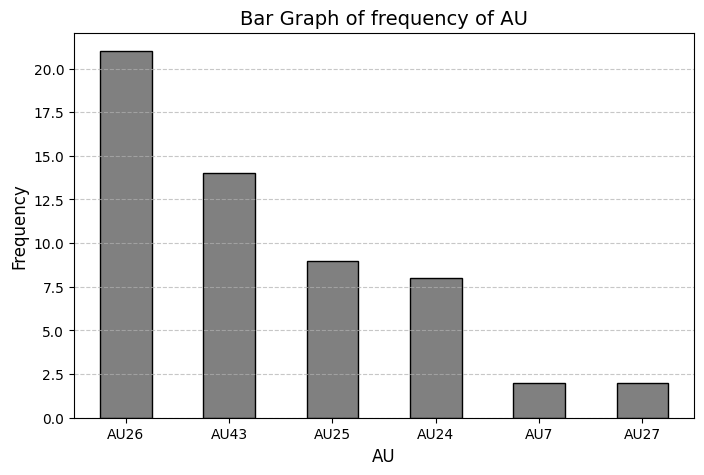

In [ ]:
# Plot frequency bar graph
frequency = relabelling_labeled['ClassLabel'].value_counts()

plt.figure(figsize=(8, 5))
frequency.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Bar Graph of frequency of AU', fontsize=14)
plt.xlabel('AU', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Unlabelled data

In [43]:
active_learning_scores_unlabeled, relabelling_unlabeled = get_active_learning_scores(None, None,pred_probs)

In [44]:
active_learning_scores_unlabeled

,AU4,AU6,AU7,AU9,AU10,AU12,AU20,AU24,AU25,AU26,AU27,AU43
0,0.739673,0.729100,0.737637,0.749572,0.743590,0.744509,0.745200,0.374930,0.443632,0.594988,0.677403,0.719766
1,0.708050,0.727116,0.735932,0.749732,0.745800,0.748605,0.631435,0.749408,0.407267,0.421254,0.749465,0.625935
2,0.704639,0.717417,0.735126,0.749745,0.747450,0.745345,0.641247,0.748813,0.412218,0.411768,0.748070,0.638161
3,0.609719,0.743918,0.712506,0.734353,0.749711,0.748164,0.749348,0.315462,0.661202,0.630455,0.748282,0.727803
4,0.747141,0.749511,0.745821,0.745815,0.749781,0.747325,0.749261,0.744711,0.693973,0.613511,0.692635,0.747538
...,...,...,...,...,...,...,...,...,...,...,...,...
12544,0.749422,0.749329,0.747909,0.749935,0.749462,0.747562,0.749476,0.729549,0.726386,0.713649,0.736801,0.649480
12545,0.749875,0.749697,0.744291,0.749981,0.749793,0.748653,0.749889,0.739706,0.722287,0.665043,0.745124,0.614338
12546,0.749249,0.749195,0.747767,0.749647,0.749496,0.747547,0.749478,0.702231,0.684813,0.710163,0.717382,0.556969
12547,0.749848,0.749854,0.747743,0.749989,0.749907,0.748797,0.749908,0.742220,0.735459,0.724363,0.746563,0.694650


In [45]:
relabelling_unlabeled

,Row_Index,AU,Predicted_Probability
0,0,AU24,0.374930
1,0,AU25,0.443632
2,1,AU25,0.407267
3,1,AU26,0.421254
4,2,AU25,0.412218
...,...,...,...
13228,12511,AU43,0.443640
13229,12520,AU26,0.486238
13230,12520,AU43,0.259947
13231,12526,AU43,0.399810


### Results
Lastly, we can obtain relevant findings of the examples by their active learning scores, and obtain the index of the examples with the lowest scores or by setting a threshold; these are the least confident examples which we will want to collect more labels for.


In [46]:
image_names = df['image_name'].unique()

In [47]:
relabelling_labeled['Image_Name']=image_names[relabelling_labeled['Index']]

In [ ]:
relabelling_labeled

,Index,ClassLabel,ActiveLearningScore,QualityOfConsensusLabeled,AnnotatorLabels,MajorityLabel,Pred,ConfidenceScore,NormalizedSumAnnotatorWeights,Image_Name
10533,877,AU26,0.372051,0.217676,"[nan, nan, 0.0, 1.0, nan, nan, nan]",0,0.267560,0.464881,0.499570,2021-06-26 11-35-02_000000000471.jpg
11167,930,AU24,0.373765,0.217029,"[nan, nan, 1.0, nan, nan, 0.0, nan]",0,0.344487,0.311027,0.482760,2021-07-20 20-02-15_000000000018.jpg
12381,1031,AU26,0.413204,0.216296,"[nan, nan, 0.0, 1.0, nan, nan, nan]",0,0.439045,0.121911,0.499570,2021-07-20 20-02-15_000000000195.jpg
12407,1033,AU43,0.385030,0.213486,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.400558,0.198885,0.482335,2021-07-20 20-02-15_000000000197.jpg
12515,1042,AU43,0.358960,0.213645,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.284994,0.430012,0.482335,2021-07-20 20-02-15_000000000206.jpg
12873,1072,AU26,0.400860,0.212495,"[nan, nan, 1.0, nan, nan, 0.0, nan]",0,0.410288,0.179425,0.495717,2021-07-20 20-02-15_000000000250.jpg
13077,1089,AU26,0.409248,0.213799,"[nan, nan, 1.0, nan, nan, nan, 0.0]",0,0.434413,0.131174,0.497019,2021-07-20 20-02-15_000000000267.jpg
13631,1135,AU43,0.355504,0.213671,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.266454,0.467092,0.482335,2021-07-20 20-02-15_000000000336.jpg
16172,1347,AU25,0.403484,0.214365,"[nan, nan, 0.0, nan, nan, nan, 1.0]",0,0.461798,0.076404,0.483515,2021-07-20 20-02-15_000000000635.jpg
16220,1351,AU25,0.376642,0.217336,"[nan, nan, 0.0, 1.0, nan, nan, nan]",0,0.339754,0.320493,0.492063,2021-07-20 20-02-15_000000000641.jpg


In [64]:
duplicates = relabelling_labeled['Image_Name'][relabelling_labeled['Image_Name'].duplicated()]


In [65]:
relabelling_unlabeled['Image_Name']=image_names[relabelling_unlabeled['Row_Index']]

In [67]:
relabelling_unlabeled

,Row_Index,AU,Predicted_Probability,Image_Name
0,0,AU24,0.374930,2022-01-31 23-54-30_000000000007.jpg
1,0,AU25,0.443632,2022-01-31 23-54-30_000000000007.jpg
2,1,AU25,0.407267,2022-01-28 05-31-32_000000000822.jpg
3,1,AU26,0.421254,2022-01-28 05-31-32_000000000822.jpg
4,2,AU25,0.412218,2022-01-28 05-31-32_000000000824.jpg
...,...,...,...,...
13228,12511,AU43,0.443640,2021-11-12 09-46-12_000000000826.jpg
13229,12520,AU26,0.486238,2021-11-12 09-46-12_000000000837.jpg
13230,12520,AU43,0.259947,2021-11-12 09-46-12_000000000837.jpg
13231,12526,AU43,0.399810,2021-11-12 09-46-12_000000000848.jpg
